In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import ast
import re
import itertools

In [2]:

path = "../data/results-damiano/results/"
path2 = "../data/results-damiano2/results/"

In [3]:
def preprocess_line(line):
       # Remove the 'device' entry
        line = re.sub(r"'device': device\(.*?\),?", "", line)
        line = re.sub(r"array\((\[.*?\])\)", r"\1", line)
        return line

def get_data(path, scenario, dataset, model, logs="/logs.txt"):
        filepath = path + scenario + "/" + dataset + "/" + model
        with open(filepath + logs, "r") as file:
                dictlist = list()
                for line in file:
                        line = preprocess_line(line)
                        dictlist.append(ast.literal_eval(line))
                return dictlist, filepath

def get_arguments(dictionary):
        base = ["dataset", "model"]
        keep = ["dataset", "model"]
        combine = []
        if "seed" in dictionary:
                base.append("seed")
                keep.append("seed")
        if "permute_classes" in dictionary:
                base.append("permute_classes")
                keep.append("permute_classes")
        if "buffer_size" in dictionary:
                base.append("buffer_size")
                keep.append("buffer_size")
        if "lr" in dictionary:
                base.append("lr")
                combine.append("lr")
        if "alpha" in dictionary:
                base.append("alpha")
                combine.append("alpha")
        if "beta" in dictionary:
                base.append("beta")
                combine.appen("beta")
        if "temperature" in dictionary:
                base.append("temperature")
                combine.append("temperature")
        if "result_type" in dictionary:
                base.append("result_type")
                keep.append("result_type")
        if "portion" in dictionary:
                base.append("portion")
                keep.append("portion")
        
        return base, keep, combine


def get_dataframe(dictlist, keep_arguments):
        df = pd.DataFrame(dictlist)
        df = df.drop(columns=[col for col in df.columns if col not in (keep_arguments)])

        #if the temperature is above 100, we used the mse approximation
        if "temperature" in keep_arguments:
                index = df['temperature'] > 100
                df["temperature"] = df["temperature"].astype("str")
                df.loc[index, 'temperature'] = 'mse'
        return df

def get_arrays(dictionary, pre_string1='accuracy', pre_string2='accmean_task'):
        dataset = dictionary['dataset']
        accmean_columns = list()
        acctask_columns = list()

        amount_task = 0
        if(any(substring in dataset for substring in ["seq-tinyimg", "seq-cifar100", 'seq-cub200'])):
                amount_task = 10
        elif(any(substring in dataset for substring in ["rot-mnist", "perm-mnist"])):
                amount_task = 20
        elif(any(substring in dataset for substring in ["seq-mnist", "seq-cifar10"])):
                amount_task = 5
        for i in range(1, amount_task+1):
                accmean_columns.append(pre_string2 + f"{i}")
                for j in range(1, i+1):
                        acctask_columns.append(pre_string1 + f"_{j}_task{i}")
        result_accuracy = accmean_columns[-1]

        return accmean_columns, acctask_columns, result_accuracy

def plotting_name(logging_name):
        if logging_name == 'er_bounds':
                return 'ER'
        elif logging_name == 'sgd':
                return 'JOINT'
        elif logging_name == 'fdr':
                return 'FDR'
        elif logging_name == 'der':
                return 'DER'
        elif logging_name == 'icarl':
                return 'iCaRL'
        elif logging_name == 'supcon':
                return 'Co2L'
        elif logging_name == 'seq-cifar10':
                return 'Cifar10'
        elif logging_name == 'seq-cifar100':
                return 'Cifar100'
        elif logging_name == 'seq-cub200':
                return 'CUB200'
        elif logging_name == 'seq-tinyimg':
                return 'TinyIMG'
        elif logging_name == 'class-il':
                return 'single-head'
        elif logging_name == 'task-il':
                return 'multi-head'
        else:
                return logging_name

def replace(dataframe, key, new_value):
        dataframe[key] = new_value

def group_df(df, filter, keep_arguments, group_arguments, result_accuracy):
        #First filter
        grouped = df
        if filter is not None:
                for key, value in filter.items():
                        grouped = grouped[grouped[key] == value]
        #Group according to all arguments
        grouped = grouped.groupby(keep_arguments + group_arguments, as_index=False).agg({result_accuracy: 'mean'})
        #print(grouped)
        #Calculate max of mean for arguments we should keep for plotting
        best = grouped.groupby(keep_arguments, as_index=False).agg({result_accuracy: 'max'})
        best = grouped.merge(best[result_accuracy], on=[result_accuracy], how='inner')
        #print(best)
        #Filter dataframe according to best arguments
        best = best.drop(result_accuracy, axis=1)
        result = df.merge(best, on=(keep_arguments + group_arguments), how='inner')
        #print(result)
        return result

In [5]:

import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker

## Output - Features 

In [6]:
# Set the font and style for the plot
plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Times New Roman'],
        'font.size': 10,
        'axes.titlesize': 12,
        'axes.labelsize': 10,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'legend.fontsize': 8,
        'figure.titlesize': 12
})

sns.set_theme(style="whitegrid", context="paper")
# Create the dictionary with the updated assignments
colors = sns.color_palette("viridis", 6)  # Requesting 6 colors to access cyan
color_dict = {
"ER": colors[1],  # blue
"ER-OR": "black",  # cyan
"DER": colors[2],  # green
"FDR": colors[3],  # violet
"iCaRL": colors[4],  # orange
"JOINT": "silver"  # black
}
datasets = ['seq-cifar100', 'seq-tinyimg']
training_setting = ['task-il','class-il']
models = ['sgd', 'er_bounds', 'der', 'fdr', 'icarl']

fig, axes = plt.subplots(1, len(datasets) * len(training_setting), figsize=(8, 3), dpi=800)
for i, setting in enumerate(list(itertools.product(training_setting, datasets))):
        data_buffer = []
        data_nobuffer = []

        if setting[1] == 'seq-cifar10':
                infinite_size = 2500
                gap = [2200, 2300]
        elif setting[1] == 'seq-cifar100':
                infinite_size = 6000
                gap = [5400, 5600]
        elif setting[1] == 'seq-tinyimg':
                infinite_size = 12000
                gap = [10800, 11200]

        for model in models:
                dictlist, filepath = get_data(path, setting[0], setting[1], model)
                arguments_base, arguments_keep, arguments_combine = get_arguments(dictlist[0])
                accmean_columns, acctask_columns, result_accuracy = get_arrays(dictlist[0])

                df = get_dataframe(dictlist, arguments_base + [result_accuracy])
                if model in ['er_bounds']:
                        df = df[df['result_type'].isin(list(['output', 'features']))]
                        df.loc[df['result_type'] == 'features', 'model'] = 'ER-OR'
                        buffer_sizes = df['buffer_size'].sort_values().tolist()
                        df["buffer_size"] = df["buffer_size"].replace(buffer_sizes[-1], infinite_size)
                elif model in ['der', 'fdr']:
                        df = df[df['result_type'].isin(list(['output']))]
                        buffer_sizes = df['buffer_size'].sort_values().tolist()
                        df["buffer_size"] = df["buffer_size"].replace(buffer_sizes[-1], infinite_size)
                else:
                        df = df[df['result_type'].isin(list(['output']))]

                df['model'] = df.apply(lambda row: plotting_name(row['model']), axis=1)
                if 'buffer_size' in arguments_base:
                        df = df[df['buffer_size'] < 50000]

                        data_buffer.append(df)
                else:
                        data_nobuffer.append(df)   
        
        data_buffer = pd.concat(data_buffer)
        data_nobuffer = pd.concat(data_nobuffer)

        all_buffer_sizes = data_buffer['buffer_size'].unique()
        df_buffer_sizes = pd.DataFrame({'buffer_size': all_buffer_sizes})
        data_nobuffer = data_nobuffer.merge(df_buffer_sizes, how='cross')

        data_buffer_OR = data_buffer[data_buffer['model'] == 'ER-OR']
        data_buffer_rest = data_buffer[data_buffer['model'] != 'ER-OR']



        sns.lineplot(data=data_buffer_rest, x='buffer_size', y=result_accuracy, hue='model',  marker='o',  markersize=5, linestyle='--', legend=False, palette=color_dict, ax=axes[i])
        sns.lineplot(data=data_nobuffer, x='buffer_size', y=result_accuracy, hue='model', marker='',  linestyle='-', legend=False, palette=color_dict, ax=axes[i], linewidth=0.5)
        sns.lineplot(data=data_buffer_OR, x='buffer_size', y=result_accuracy, hue='model',  marker='D',  markersize=5, linestyle=':', legend=False, palette=color_dict, ax=axes[i])



        # Remove the boxes around each plot
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)
        axes[i].spines['left'].set_visible(False)
        axes[i].spines['bottom'].set_visible(False)


        y_min = min(data_buffer[result_accuracy].min(), data_nobuffer[result_accuracy].min(), data_buffer_OR[result_accuracy].min())
        y_max = max(data_buffer[result_accuracy].max(), data_nobuffer[result_accuracy].max(), data_buffer_OR[result_accuracy].max())
        axes[i].set_ylim(y_min - 5, y_max)

        current_yticks = axes[i].get_yticks()
        #y_min, y_max = axes[i].get_ylim()  # Store exact limits
        axes[i].set_yticks(current_yticks)  # Freeze ticks
        #axes[i].set_ylim((y_min, y_max))  # Reset exact limits

        if setting[1] == 'seq-cifar10':
                xticks = [0, 200, 500, 1000, 1500, 2000, 2500]
        elif setting[1] == 'seq-cifar100':
                xticks = [0, 1000, 2000, 3000, 4000, 5000, 6000]
        elif setting[1] == 'seq-tinyimg':
                xticks = [0, 2000, 4000, 6000, 8000, 10000, 12000]
        
        axes[i].set_xticks(xticks)  # Ensure tick positions remain the same
        xticklabels = [str(int(tick)) if tick != max(xticks) else 'inf' for tick in xticks]  # Replace max tick with 'inf'
        axes[i].set_xticklabels(xticklabels)  # Set the new labels

        #Make the fontsize of the axis smaller
        for tick in axes[i].get_xticklabels():
                tick.set_rotation(45)
        axes[i].tick_params(axis='both', which='major', labelsize=8)
        
        # # Optional: Add a small gap visual indicator
        # #axes[i].axvline(x=gap[0], color='grey', linestyle='--', lw=1, alpha=0.7)
        # #axes[i].axvline(x=gap[1], color='grey', linestyle='--', lw=1, alpha=0.7)
        # #y_pos = axes[i].get_ylim()[0] - (axes[i].get_ylim()[1] - axes[i].get_ylim()[0]) * 0.05  # Small offset below x-axis
        # axes[i].text((gap[0] + gap[1])//2, y_min, "...", fontsize=14, ha='center', va='center', color='black', zorder=4)
        # axes[i].text((gap[0] + gap[1])//2, y_max, "", fontsize=14, ha='center', va='center', color='black', zorder=4)

        # axes[i].fill_betweenx((y_min+1, y_max-1), gap[0], gap[1], color='white', zorder=3)
        
        # Customize the grid  
        axes[i].grid(visible=True, which='major', axis='x', linestyle=':', linewidth=0.5, color='lightgrey')  # Dashed grid for x-axis
        axes[i].grid(visible=True, which='major', axis='y', linestyle='--', linewidth=0.5, color='lightgrey')     

        axes[i].set_title(f'{plotting_name(setting[1])} ({plotting_name(setting[0])})', fontsize=10)
        axes[i].set_xlabel("Buffer Size")



        if i==0:
                axes[i].set_ylabel("Test Accuracy [%]", fontsize=8)
        else:
                axes[i].set_ylabel("")

        
legend_handles = []
for label, color in color_dict.items():
        if label == "JOINT":
                legend_handles.append(mlines.Line2D([0], [0], color=color, label=label))
        elif label == "ER-OR":
                legend_handles.append(mlines.Line2D([0], [0], color=color, marker='o', linestyle=':', markersize=4, label=label))
        else:
                legend_handles.append(mlines.Line2D([0], [0], color=color, marker='o', markersize=4, label=label))
labels = color_dict.keys()
# Move ER-OR to the first position in the legend
legend_handles = [legend_handles[1]] + legend_handles[:1] + legend_handles[2:]
labels = ['ER-OR'] + [label for label in labels if label != 'ER-OR']
fig.legend(legend_handles, labels, loc='center', bbox_to_anchor=(1.05, 0.5), ncol=1, title_fontsize=8, fontsize=8)
fig.tight_layout()
fig.savefig("./paper" + f"/Output_vs_Features_G_vir.pdf", bbox_inches='tight')
fig.clf() 

<Figure size 6400x2400 with 0 Axes>

In [ ]:
# Set the font and style for the plot
plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Times New Roman'],
        'font.size': 10,
        'axes.titlesize': 12,
        'axes.labelsize': 10,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'legend.fontsize': 8,
        'figure.titlesize': 12
})

sns.set_theme(style="whitegrid", context="paper")
# Create the dictionary with the updated assignments
colors = sns.color_palette("viridis", 6)  # Requesting 6 colors to access cyan
color_dict = {
"ER": colors[1],  # blue
"ER-OR": "black",  # cyan
}
datasets = ['seq-cifar100', 'seq-tinyimg', 'seq-cub200']
training_setting = ['task-il','class-il']
models = ['er_bounds']

fig, axes = plt.subplots(1, len(datasets) * len(training_setting), figsize=(12, 3), dpi=800)
for i, setting in enumerate(list(itertools.product(training_setting, datasets))):
        data_buffer = []
        data_nobuffer = []

        if setting[1] == 'seq-cifar10':
                infinite_size = 2500
                gap = [2200, 2300]
        elif setting[1] == 'seq-cifar100':
                infinite_size = 6000
                gap = [5400, 5600]
        elif setting[1] == 'seq-tinyimg':
                infinite_size = 12000
                gap = [10800, 11200]

        for model in models:
                if setting[1] == 'seq-cub200': 
                    dictlist, filepath = get_data(path2, setting[0], setting[1], model)
                else: 
                    dictlist, filepath = get_data(path, setting[0], setting[1], model)
                arguments_base, arguments_keep, arguments_combine = get_arguments(dictlist[0])
                accmean_columns, acctask_columns, result_accuracy = get_arrays(dictlist[0])

                df = get_dataframe(dictlist, arguments_base + [result_accuracy])
                if model in ['er_bounds']:
                        df = df[df['result_type'].isin(list(['output', 'features']))]
                        df.loc[df['result_type'] == 'features', 'model'] = 'ER-OR'
                        buffer_sizes = df['buffer_size'].sort_values().tolist()
                        df["buffer_size"] = df["buffer_size"].replace(buffer_sizes[-1], infinite_size)
                elif model in ['der', 'fdr']:
                        df = df[df['result_type'].isin(list(['output']))]
                        buffer_sizes = df['buffer_size'].sort_values().tolist()
                        df["buffer_size"] = df["buffer_size"].replace(buffer_sizes[-1], infinite_size)
                else:
                        df = df[df['result_type'].isin(list(['output']))]

                df['model'] = df.apply(lambda row: plotting_name(row['model']), axis=1)
                if 'buffer_size' in arguments_base:
                        df = df[df['buffer_size'] < 50000]
                        data_buffer.append(df)
                else:
                        data_nobuffer.append(df)   
        
        data_buffer = pd.concat(data_buffer)
        #data_nobuffer = pd.concat(data_nobuffer)

        all_buffer_sizes = data_buffer['buffer_size'].unique()
        df_buffer_sizes = pd.DataFrame({'buffer_size': all_buffer_sizes})
        #data_nobuffer = data_nobuffer.merge(df_buffer_sizes, how='cross')

        data_buffer_OR = data_buffer[data_buffer['model'] == 'ER-OR']
        data_buffer_rest = data_buffer[data_buffer['model'] != 'ER-OR']



        sns.lineplot(data=data_buffer_rest, x='buffer_size', y=result_accuracy, hue='model',  marker='o',  markersize=5, linestyle='--', legend=False, palette=color_dict, ax=axes[i])
        #sns.lineplot(data=data_nobuffer, x='buffer_size', y=result_accuracy, hue='model', marker='',  linestyle='-', legend=False, palette=color_dict, ax=axes[i], linewidth=0.5)
        sns.lineplot(data=data_buffer_OR, x='buffer_size', y=result_accuracy, hue='model',  marker='D',  markersize=5, linestyle=':', legend=False, palette=color_dict, ax=axes[i])



        # Remove the boxes around each plot
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)
        axes[i].spines['left'].set_visible(False)
        axes[i].spines['bottom'].set_visible(False)


        y_min = min(data_buffer[result_accuracy].min(),  data_buffer_OR[result_accuracy].min())
        y_max = max(data_buffer[result_accuracy].max(),  data_buffer_OR[result_accuracy].max())
        axes[i].set_ylim(y_min - 5, y_max)

        current_yticks = axes[i].get_yticks()
        #y_min, y_max = axes[i].get_ylim()  # Store exact limits
        axes[i].set_yticks(current_yticks)  # Freeze ticks
        #axes[i].set_ylim((y_min, y_max))  # Reset exact limits

        if setting[1] == 'seq-cifar10':
                xticks = [0, 200, 500, 1000, 1500, 2000, 2500]
        elif setting[1] == 'seq-cifar100':
                xticks = [0, 1000, 2000, 3000, 4000, 5000, 6000]
                axes[i].axvline(x=100, color='purple', linestyle='--', lw=1, alpha=0.7)
                axes[i].axhline(y=80 if setting[0] == 'task-il' else 47, color='purple', linestyle='--', lw=1, alpha=0.7)
        elif setting[1] == 'seq-tinyimg':
                xticks = [0, 2000, 4000, 6000, 8000, 10000, 12000]
                axes[i].axvline(x=200, color='purple', linestyle='--', lw=1, alpha=0.7)
                axes[i].axhline(y=65 if setting[0] == 'task-il' else 36, color='purple', linestyle='--', lw=1, alpha=0.7)
        elif setting[1] == 'seq-cub200':
                xticks = [0, 2000, 4000, 6000, 8000, 10000, 12000]
                axes[i].axvline(x=200, color='purple', linestyle='--', lw=1, alpha=0.7)
                axes[i].axhline(y=78 if setting[0] == 'task-il' else 62, color='purple', linestyle='--', lw=1, alpha=0.7)
        
        axes[i].set_xticks(xticks)  # Ensure tick positions remain the same
        xticklabels = [str(int(tick)) if tick != max(xticks) else 'inf' for tick in xticks]  # Replace max tick with 'inf'
        axes[i].set_xticklabels(xticklabels)  # Set the new labels
        axes[i].set_xlim(-0.0001)

        #Make the fontsize of the axis smaller
        for tick in axes[i].get_xticklabels():
                tick.set_rotation(45)
        axes[i].tick_params(axis='both', which='major', labelsize=8)
        
        axes[i].set_xscale('symlog', linthresh=200)
        
        # Customize the grid  
        axes[i].grid(visible=True, which='major', axis='x', linestyle=':', linewidth=0.5, color='lightgrey')  # Dashed grid for x-axis
        axes[i].grid(visible=True, which='major', axis='y', linestyle='--', linewidth=0.5, color='lightgrey')     

        axes[i].set_title(f'{plotting_name(setting[1])} ({plotting_name(setting[0])})', fontsize=10)
        axes[i].set_xlabel("Buffer Size")



        if i==0:
                axes[i].set_ylabel("Test Accuracy [%]", fontsize=8)
        else:
                axes[i].set_ylabel("")

        
        

        
legend_handles = []
for label, color in color_dict.items():
        if label == "JOINT":
                legend_handles.append(mlines.Line2D([0], [0], color=color, label=label))
        elif label == "ER-OR":
                legend_handles.append(mlines.Line2D([0], [0], color=color, marker='o', linestyle=':', markersize=4, label=label))
        else:
                legend_handles.append(mlines.Line2D([0], [0], color=color, marker='o', markersize=4, label=label))
labels = color_dict.keys()
# Move ER-OR to the first position in the legend
legend_handles = [legend_handles[1]] + legend_handles[:1] + legend_handles[2:]
labels = ['ER-OR'] + [label for label in labels if label != 'ER-OR']
fig.legend(legend_handles, labels, loc='center', bbox_to_anchor=(0.14, 0.5), ncol=1, title_fontsize=8, fontsize=8)
fig.tight_layout()
fig.savefig("./paper" + f"/Output_vs_Features_G_alldata.pdf", bbox_inches='tight')
fig.clf() 

## NC plot

In [ ]:
sns.set_theme(style="whitegrid")
#color_mapping = {"accuracy": palette[2], "train_dataset": palette[1], "buffer": palette[0]}
line_mapping = {'Current Task': (1, 0), 'Previous Tasks': (5, 2)}
datasets = ['seq-cifar10', 'seq-tinyimg']
training_setting = ['class-il', 'task-il']
model = 'er_bounds'
fig, axes = plt.subplots(1, len(datasets)*len(training_setting), figsize=(16, 4))

for i, (ax, setting) in enumerate(zip(axes, list(itertools.product(datasets, training_setting)))):
        dictlist, filepath = get_data(path, setting[1], setting[0], model, '/logs.txt')
        arguments_base, arguments_keep, arguments_combine = get_arguments(dictlist[0])
        accmean_columns, acctask_columns, result_accuracy = get_arrays(dictlist[0])

        df_accuracy = get_dataframe(dictlist, arguments_base + acctask_columns[-len(accmean_columns):])
        df_accuracy = df_accuracy[df_accuracy['buffer_size'] < 50000]
        df_accuracy = df_accuracy[df_accuracy['result_type'].isin(['buffer'])]
        df_accuracy['Current Task'] = df_accuracy[acctask_columns[-1]]
        df_accuracy['Previous Tasks'] = df_accuracy[acctask_columns[-3]]
        df_accuracy = pd.melt(df_accuracy, id_vars=arguments_base, value_vars=['Current Task', 'Previous Tasks'], var_name='task', value_name='accuracy')

        dictlist, filepath = get_data(path, setting[1], setting[0], model, '/logs_NC.txt')
        _, within_var, _ = get_arrays(dictlist[0], 'within_var')
        _, cos_distance, _ = get_arrays(dictlist[0], 'cos_distance')

        df_nc = get_dataframe(dictlist, arguments_base + within_var[-len(accmean_columns):] + within_var[-len(accmean_columns):])
        df_nc = df_nc[df_nc['buffer_size'] < 50000]
        df_nc['Current Task'] = df_nc[within_var[-1]]
        df_nc['Previous Tasks'] = df_nc[within_var[-4]]
        df_nc = pd.melt(df_nc, id_vars=arguments_base, value_vars=['Current Task', 'Previous Tasks'], var_name='task', value_name='NC')
        

        sns.lineplot(data=df_nc, x='buffer_size', y='NC', hue='result_type', style='task', marker='o', dashes=line_mapping, legend=(i==0))#, ax=ax, palette=color_mapping)

        ax2 = ax.twinx()
        sns.lineplot(data=df_accuracy, x='buffer_size', y='accuracy', style='task',  marker='o', dashes=line_mapping, legend=(i==0), ax=ax2)#, color=color_mapping['accuracy'])   
        
        #if i==0:
        #        handles, labels = ax.get_legend_handles_labels()
        #        ax.legend_.remove()

        ax.set_title(plotting_name(setting[0]) + ' (' + plotting_name(setting[1]) + ')')
        ax.set_xlabel("Buffer Size")
        #if i==0:
                #ax.set_ylabel("NC")
                #ax2.set_ylabel('Test Accuracy', color=color_mapping['accuracy'])
                #ax2.tick_params(axis='y', labelcolor=color_mapping['accuracy'])
        #else:
                #ax.set_ylabel("")
                #ax2.set_ylabel('')

#fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, 0.05), ncol=5)
fig.tight_layout(rect=[0, 0.05, 1, 1])
# fig.savefig(path + f"/BufferSize_vs_NC_TIL.png")
# fig.clf() 

In [ ]:
# Set the font and style for the plot
plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Times New Roman'],
        'font.size': 10,
        'axes.titlesize': 12,
        'axes.labelsize': 10,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'legend.fontsize': 8,
        'figure.titlesize': 12
})

sns.set_theme(style="whitegrid", context="paper")
# Create the dictionary with the updated assignments
palette = sns.color_palette("coolwarm", 2)  # Requesting 6 colors to access cyan

datasets = {'seq-cifar100': [0], 'seq-tinyimg': [0], 'seq-cub200': [0]}
model = 'er_bounds'
training_settings = ['task-il', 'class-il']
fig, axes = plt.subplots(1, 6, figsize=(12, 3), dpi=800)
#plt.rcParams['text.usetex'] = True # TeX rendering

total = 0
for col  in range(len(training_settings)):
        for row, (c_dataset, buffer_sizes) in enumerate(datasets.items()):

                if c_dataset == 'seq-cub200': 
                    p = path2
                else: 
                    p = path
                dictlist, _ = get_data(p, training_settings[col], c_dataset, model, "/logs_NC.txt")
                arguments_base, _, _ = get_arguments(dictlist[0])
                tasks, within_var, _ = get_arrays(dictlist[0], 'within_var')
                _, between_var, _ = get_arrays(dictlist[0], 'between_var')
                _, l2_distance, _ = get_arrays(dictlist[0], 'l2_distance')
                _, cos_distance, _ = get_arrays(dictlist[0], 'cos_distance')
                df = get_dataframe(dictlist, arguments_base + ['seed'] + within_var + between_var + l2_distance + cos_distance)
                df = df[df['result_type'].isin(list(['train_dataset']))]
                df = df[df['permute_classes']==0]


                
                buffer_size = buffer_sizes[0]
                ax = axes[total] #attention
                current_df = df[df['buffer_size'] == buffer_size]

                results = []
                for i in range(1, len(tasks) + 1):
                        for j in range(1, i+1):
                                current_result = pd.DataFrame({'training_task': i, 'evaluating_task': j, 
                                                        'accuracy': (current_df[f'within_var_{j}_task{i}'] / current_df[f'between_var_{j}_task{i}']), 'result_type': current_df['result_type'], 'task_type':j==i})
                                results.append(current_result) 

                results = pd.concat(results)
                # sns.lineplot(data=results, x='training_task', y='accuracy', hue='evaluating_task', style='result_type', marker='o', legend=True, ax=ax, palette=palette)
                sns.barplot(data=results, x='training_task', y='accuracy', hue='task_type', ax=ax, errorbar=('ci', 95), errwidth=2, palette=palette, zorder=0, edgecolor='black', dodge=False)
                
                ax.set_title(f'{plotting_name(c_dataset)} ({plotting_name(training_settings[col])})')
                ax.set_xlabel("Training Task")
                if total==0:
                        ax.set_ylabel(f"Neural Collapse")
                else:
                        ax.set_ylabel("")

                # Add dotted grid lines
                ax.grid(True, linestyle='--', linewidth=1.0, axis='y', zorder=2)

                # Remove the boxes around each plot
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                ax.spines['left'].set_visible(False)
                ax.spines['bottom'].set_visible(False)

                ax.legend_.remove()
                total += 1
                
# labels = ["1", "3", "5", "7", "9"]
# legend_handles = [mpatches.Patch(color=palette[i]) for i in range(5)]
#fig.legend(legend_handles, labels, loc='center', bbox_to_anchor=(0.5, 0.05), ncol=6)
handles, _ = axes[0].get_legend_handles_labels()
labels = ['Previous Tasks','Current Task']
fig.legend(handles, labels, bbox_to_anchor=(0.65, 0.11), ncol=2)
fig.tight_layout(rect=[0, 0.05, 1, 1])
# fig.savefig('./paper' + f"/NC_sgd_all_G.pdf", dpi=800)
# fig.clf() 

In [ ]:
# Set the font and style for the plot
plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Times New Roman'],
        'font.size': 10,
        'axes.titlesize': 12,
        'axes.labelsize': 10,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'legend.fontsize': 8,
        'figure.titlesize': 12
})

sns.set_theme(style="whitegrid", context="paper")
# Create the dictionary with the updated assignments
palette = sns.color_palette("coolwarm", 2)  # Requesting 6 colors to access cyan

datasets = {'seq-cifar100': [0], 'seq-tinyimg': [0], 'seq-cub200': [0]}
model = 'er_bounds'
training_settings = ['task-il']
fig, axes = plt.subplots(1, 3, figsize=(6, 2.5), dpi=800)
#plt.rcParams['text.usetex'] = True # TeX rendering

total = 0
for col  in range(len(training_settings)):
        for row, (c_dataset, buffer_sizes) in enumerate(datasets.items()):

                if c_dataset == 'seq-cub200': 
                    p = path2
                else: 
                    p = path
                dictlist, _ = get_data(p, training_settings[col], c_dataset, model, "/logs_NC.txt")
                arguments_base, _, _ = get_arguments(dictlist[0])
                tasks, within_var, _ = get_arrays(dictlist[0], 'within_var')
                _, between_var, _ = get_arrays(dictlist[0], 'between_var')
                _, l2_distance, _ = get_arrays(dictlist[0], 'l2_distance')
                _, cos_distance, _ = get_arrays(dictlist[0], 'cos_distance')
                df = get_dataframe(dictlist, arguments_base + ['seed'] + within_var + between_var + l2_distance + cos_distance)
                df = df[df['result_type'].isin(list(['train_dataset']))]
                df = df[df['permute_classes']==0]



                buffer_size = buffer_sizes[0]
                ax = axes[total] #attention
                current_df = df[df['buffer_size'] == buffer_size]

                results = []
                for i in range(1, len(tasks) + 1):
                        for j in range(1, i+1):
                                current_result = pd.DataFrame({'training_task': i, 'evaluating_task': j, 
                                                        'accuracy': (current_df[f'within_var_{j}_task{i}'] / current_df[f'between_var_{j}_task{i}']), 'result_type': current_df['result_type'], 'task_type':j==i})
                                results.append(current_result) 

                results = pd.concat(results)
                # sns.lineplot(data=results, x='training_task', y='accuracy', hue='evaluating_task', style='result_type', marker='o', legend=True, ax=ax, palette=palette)
                results_task_1 = results[results['evaluating_task'] == 1]
                sns.lineplot(data=results_task_1, x='training_task', y='accuracy', linestyle="--",ax=ax, errorbar=('ci', 95), palette=palette, zorder=0, label='Task 1')
                sns.lineplot(data=results, x='training_task', y='accuracy', hue='task_type', ax=ax, errorbar=('ci', 95), palette=palette, zorder=0)
                
                ax.set_title(f'{plotting_name(c_dataset)} ({plotting_name(training_settings[col])})')
                ax.set_xlabel("Training Task")
                if total==0:
                        ax.set_ylabel(f"Neural Collapse")
                else:
                        ax.set_ylabel("")

                # Add dotted grid lines
                ax.grid(True, linestyle='--', linewidth=1.0, axis='y', zorder=2)

                # Remove the boxes around each plot
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                ax.spines['left'].set_visible(False)
                ax.spines['bottom'].set_visible(False)

                ax.legend_.remove()
                total += 1
                
# labels = ["1", "3", "5", "7", "9"]
# legend_handles = [mpatches.Patch(color=palette[i]) for i in range(5)]
#fig.legend(legend_handles, labels, loc='center', bbox_to_anchor=(0.5, 0.05), ncol=6)
handles, labels = axes[0].get_legend_handles_labels()
labels = ['Task 1','Previous Tasks Average', 'Current Task']
fig.legend(handles, labels, bbox_to_anchor=(0.9, 0.1), ncol=3)
fig.tight_layout(rect=[0, 0.05, 1, 1])
fig.savefig('./paper' + f"/NC_sgd_til_task1_G.pdf", dpi=800)
fig.clf() 

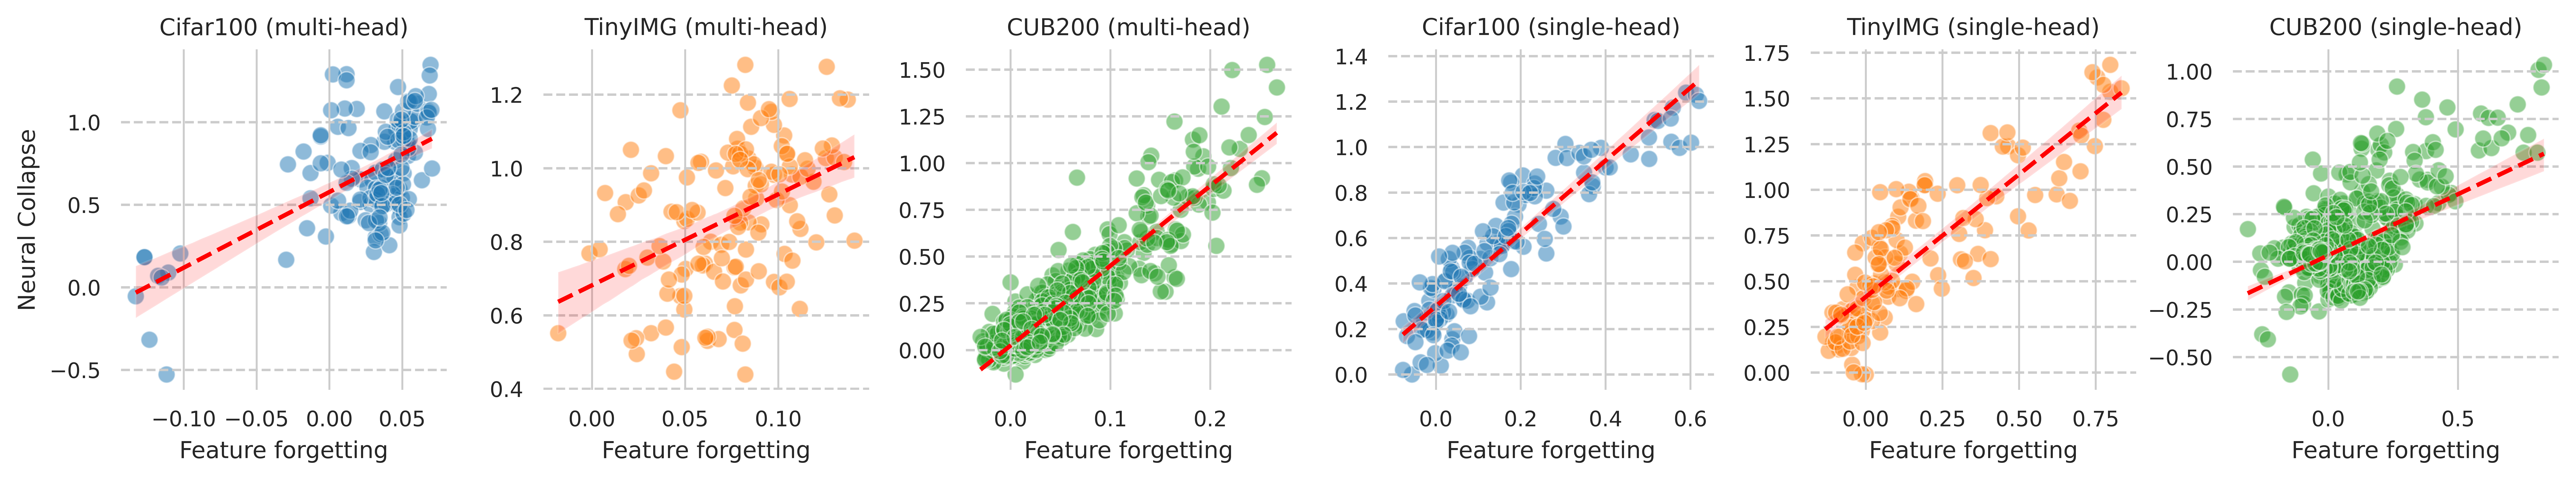

In [8]:
# Set the font and style for the plot
plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Times New Roman'],
        'font.size': 10,
        'axes.titlesize': 12,
        'axes.labelsize': 10,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'legend.fontsize': 8,
        'figure.titlesize': 12
})

sns.set_theme(style="whitegrid", context="paper")
# Create the dictionary with the updated assignments
palette = sns.color_palette("tab10", 3)  # Requesting 6 colors to access cyan

datasets = ['seq-cifar100','seq-tinyimg', 'seq-cub200']
model = 'er_bounds'
training_settings = ['task-il', 'class-il']
fig, axes = plt.subplots(1, 6, figsize=(15, 3), dpi=800)
#plt.rcParams['text.usetex'] = True # TeX rendering

total = 0
for col  in range(len(training_settings)):
        for row, c_dataset in enumerate(datasets):

                if c_dataset == 'seq-cub200': 
                    p = path2
                else: 
                    p = path

                p = path2
                    
                dictlist, _ = get_data(p, training_settings[col], c_dataset, model, "/logs_NC.txt")
                arguments_base, _, _ = get_arguments(dictlist[0])
                tasks, within_var, _ = get_arrays(dictlist[0], 'within_var')
                _, between_var, _ = get_arrays(dictlist[0], 'between_var')
                _, l2_distance, _ = get_arrays(dictlist[0], 'l2_distance')
                _, cos_distance, _ = get_arrays(dictlist[0], 'cos_distance')
                df_nc = get_dataframe(dictlist, arguments_base + ['seed'] + within_var + between_var + l2_distance + cos_distance)
                df_nc = df_nc[df_nc['result_type'].isin(list(['test_dataset']))]
                df_nc = df_nc[df_nc['permute_classes']==0]
                df_nc = df_nc[df_nc['model']=='er_bounds']
                df_nc = df_nc[df_nc['buffer_size']<=5000]


                dictlist, _ = get_data(p, training_settings[col], c_dataset, model, "/logs.txt")
                arguments_base, arguments_keep, arguments_combine = get_arguments(dictlist[0])
                accmean_columns, acctask_columns, result_accuracy = get_arrays(dictlist[0])

                df_acc = get_dataframe(dictlist, arguments_base + [result_accuracy] + acctask_columns)
                for i in range(1, 11):
                        for j in range(1, i):
                                df_acc[f'forgetting_{j}_task{i}'] = df_acc[f'accuracy_{j}_task{j}'] - df_acc[f'accuracy_{j}_task{i}']
                df_acc = df_acc[df_acc['result_type'].isin(list(['features']))]
                df_acc = df_acc[df_acc['permute_classes']==0]
                df_acc = df_acc[df_acc['buffer_size']<=5000]
                df_acc = df_acc[df_acc['model']=='er_bounds']
                
        
                ax = axes[total] #attention

                results = []
                
                df_merged = pd.merge(df_nc, df_acc, on=['seed', 'buffer_size', 'permute_classes', 'model', 'lr', 'dataset'], how='inner')

                ax = axes[total] #attention

                results = []
                for i in range(1, 11):
                        for j in range(1, i):
                                current_result = pd.DataFrame({
                                        'training_task': i, 'evaluating_task': j, 'task_delta': i-j,
                                        'buffer_size': df_merged['buffer_size'], 
                                        'NC': (df_merged[f'within_var_{j}_task{i}']/df_merged[f'between_var_{j}_task{i}']) , 
                                        'NC_delta': (df_merged[f'within_var_{j}_task{i}']/df_merged[f'between_var_{j}_task{i}']- df_merged[f'within_var_{j}_task{j}']/df_merged[f'between_var_{j}_task{j}']) ,
                                        'avg_accuracy': df_merged[result_accuracy]/100, 
                                        'forgetting': df_merged[f'forgetting_{j}_task{i}']/df_merged[result_accuracy], 
                                        'seed': df_merged['seed']})
                                results.append(current_result) 


                results = pd.concat(results)
                # sns.lineplot(data=results, x='training_task', y='accuracy', hue='evaluating_task', style='result_type', marker='o', legend=True, ax=ax, palette=palette)
                sns.regplot(data=results, x='forgetting', y='NC_delta', ax=ax, scatter=False, color='red', line_kws={"linestyle": "--"})
                sns.scatterplot(data=results, x='forgetting', y='NC_delta', ax=ax,  zorder=0, marker='o', edgecolor='white', s=50, color=palette[row], alpha=0.5)
                
                ax.set_title(f'{plotting_name(c_dataset)} ({plotting_name(training_settings[col])})')
                ax.set_xlabel("Feature forgetting")
                if total==0:
                        ax.set_ylabel(f"Neural Collapse")
                else:
                        ax.set_ylabel("")

                # Add dotted grid lines
                ax.grid(True, linestyle='--', linewidth=1.0, axis='y', zorder=2)

                # Remove the boxes around each plot
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                ax.spines['left'].set_visible(False)
                ax.spines['bottom'].set_visible(False)

                # ax.legend_.remove()
                total += 1
                
# labels = ["1", "3", "5", "7", "9"]
# legend_handles = [mpatches.Patch(color=palette[i]) for i in range(5)]
#fig.legend(legend_handles, labels, loc='center', bbox_to_anchor=(0.5, 0.05), ncol=6)
handles, labels = axes[0].get_legend_handles_labels()
labels = ['Task 1','Previous Tasks Average', 'Current Task']
# fig.legend(handles, labels, bbox_to_anchor=(0.9, 0.1), ncol=3)
fig.tight_layout(rect=[0, 0.05, 1, 1])
# fig.savefig('./paper' + f"/NC_FF_til.pdf", dpi=800)
# fig.clf() 

In [ ]:
df_acc

In [ ]:
datasets = {'seq-cifar100': [2000], 'seq-tinyimg': [5000]}
model = 'er_bounds'
training_settings = ['class-il', 'task-il']
fig, axes = plt.subplots(1, 4, figsize=(14, 3.5), dpi=800)


for col1, (c_dataset, buffer_sizes) in enumerate(datasets.items()):
        for k in range(len(training_settings)):
                dictlist, _ = get_data(path, training_settings[k], c_dataset, model, "/logs_NC.txt")
                arguments_base, _, _ = get_arguments(dictlist[0])
                arguments_base.remove('seed')
                tasks, within_var, _ = get_arrays(dictlist[0], 'within_var')
                _, between_var, _ = get_arrays(dictlist[0], 'between_var')
                _, l2_distance, _ = get_arrays(dictlist[0], 'l2_distance')
                _, cos_distance, _ = get_arrays(dictlist[0], 'cos_distance')
                df = get_dataframe(dictlist, arguments_base + ['seed'] + within_var + between_var + l2_distance + cos_distance)
                df = df[df['result_type'].isin(list(['buffer', 'train_dataset']))]

                for col2, buffer_size in enumerate(buffer_sizes):
                        ax = axes[k+ 2*col1 + col2] #attention
                        current_df = df[df['buffer_size'] == buffer_size].copy()
                        
                        #Split buffer and train rows
                        buffer_df = current_df[current_df['result_type'] == 'buffer'].set_index('seed')
                        train_df = current_df[current_df['result_type'] == 'train_dataset'].set_index('seed')

                        # Drop the 'result' column before subtraction
                        buffer_df = buffer_df.drop(columns=arguments_base)
                        train_df = train_df.drop(columns=arguments_base)

                        current_df = (train_df - buffer_df)

                        results = []
                        for i in range(0, 5):
                                to_average = []
                                for j in range(1, 10+1-i):
                                        to_average.append(f'within_var_{j}_task{j+i}')
                                current_result = pd.DataFrame({'tasks_afterwards': i, 'var_mean': (current_df[to_average].mean(axis=0))})
                                results.append(current_result) 

                        results = pd.concat(results)
                        

                        sns.barplot(data=results, x='tasks_afterwards', y='var_mean', errorbar=('ci', 95), errwidth=2, zorder=0, edgecolor='black', color=sns.color_palette("deep")[0], ax=ax)
                
                        current_yticks = ax.get_yticks()[1:][::2]
                        y_min, y_max = ax.get_ylim()  # Store exact limits

                        ax.set_yticks(current_yticks)  # Freeze ticks
                        ax.set_ylim((y_min, y_max))  # Reset exact limits
                        
                        ax.set_title(f'{plotting_name(c_dataset)}, {plotting_name(training_settings[k])}-head')
                        ax.set_xlabel("Tasks passed")
                        if k+col1+col2==0:
                                ax.set_ylabel("Within Class Variance")
                        else:
                                ax.set_ylabel("")
                        ax.grid(True, linestyle='--', linewidth=0.5, axis='y', zorder=0)

plt.tight_layout()             
        # fig.savefig(path + f"/NC_fixed_buffer.pdf", dpi=800)
        # fig.clf()  

In [ ]:
datasets = {'seq-cifar100': [500], 'seq-tinyimg': [1000], 'seq-cub200': [200]}
model = 'er_bounds'
training_settings = ['class-il', 'task-il']

plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Times New Roman'],
        'font.size': 10,
        'axes.titlesize': 12,
        'axes.labelsize': 10,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'legend.fontsize': 8,
        'figure.titlesize': 12
})

sns.set_theme(style="whitegrid", context="paper")
# Create the dictionary with the updated assignments
palette = sns.color_palette("Set1") 

fig, axes = plt.subplots(1, 3, figsize=(8, 3), dpi=800, sharey=False)




for col1, (c_dataset, buffer_sizes) in enumerate(datasets.items()):
        results = []
        ax = axes[col1] #attention
        for k in range(len(training_settings)):

                if setting[0] == 'seq-cub200': 
                        p = path2
                else: 
                        p = path
                dictlist, _ = get_data(p, training_settings[k], c_dataset, model, "/logs_NC.txt")
                arguments_base, _, _ = get_arguments(dictlist[0])
                arguments_base.remove('seed')
                tasks, within_var, _ = get_arrays(dictlist[0], 'within_var')
                _, between_var, _ = get_arrays(dictlist[0], 'between_var')
                _, l2_distance, _ = get_arrays(dictlist[0], 'l2_distance')
                _, cos_distance, _ = get_arrays(dictlist[0], 'cos_distance')
                df = get_dataframe(dictlist, arguments_base + ['seed'] + within_var + between_var + l2_distance + cos_distance)
                df = df[df['result_type'].isin(list(['buffer', 'train_dataset']))]

                for col2, buffer_size in enumerate(buffer_sizes):
                        current_df = df[df['buffer_size'] == buffer_size].copy()
                        
                        #Split buffer and train rows
                        buffer_df = current_df[current_df['result_type'] == 'buffer'].set_index('seed')
                        train_df = current_df[current_df['result_type'] == 'train_dataset'].set_index('seed')

                        # Drop the 'result' column before subtraction
                        buffer_df = buffer_df.drop(columns=arguments_base)
                        train_df = train_df.drop(columns=arguments_base)

                        current_df = (train_df - buffer_df)

                        for i in range(0, 9):
                                to_average = []
                                for j in range(1, 10+1-i):
                                        to_average.append(f'within_var_{j}_task{j+i}')
                                current_result = pd.DataFrame({'tasks_afterwards': i, 'var_mean': (current_df[to_average].mean(axis=0)), 'setting': training_settings[k]})
                                results.append(current_result) 

        results = pd.concat(results)
                        

        # Remove the boxes around each plot
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

        
        sns.lineplot(data=results, x='tasks_afterwards', y='var_mean', errorbar=('ci', 95), zorder=0, palette=palette, hue='setting', style='setting', ax=ax, marker='o', dashes=False)


        ax.legend_.remove()

        current_yticks = ax.get_yticks()[1:][::2]
        y_min, y_max = ax.get_ylim()  # Store exact limits

        # ax.set_yticks(current_yticks)  # Freeze ticks
        # ax.set_ylim((y_min, y_max))  # Reset exact limits
        
        ax.set_title(f'{plotting_name(c_dataset)}')
        ax.set_xlabel("Task switches")
        ax.set_ylabel("")
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        #ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
        ax.grid(True, linestyle='--', linewidth=0.5, axis='both', zorder=2)

fig.suptitle("Within Class Variance Train-Buffer", fontsize=10, y=.95)
 
plt.tight_layout()           
handles, _ = ax.get_legend_handles_labels()
labels = ['single-head', 'multi-head']
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.6, 0.4), ncol=1)
            
# fig.savefig("./paper" + f"/NC_fixed_buffer_G.pdf", dpi=800)
# fig.clf()   


In [ ]:
datasets = {'seq-cifar100': [500], 'seq-tinyimg': [1000], 'seq-cub200': [200]}
model = 'er_bounds'
training_settings = ['class-il', 'task-il']

plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Times New Roman'],
        'font.size': 10,
        'axes.titlesize': 12,
        'axes.labelsize': 10,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'legend.fontsize': 8,
        'figure.titlesize': 12
})

sns.set_theme(style="whitegrid", context="paper")
# Create the dictionary with the updated assignments
palette = sns.color_palette("Set1") 

fig, axes = plt.subplots(1, 3, figsize=(8, 3), dpi=800, sharey=True)


for col1, (c_dataset, buffer_sizes) in enumerate(datasets.items()):
        results = []
        ax = axes[col1] #attention
        for k in range(len(training_settings)):

                if setting[0] == 'seq-cub200': 
                        p = path2
                else: 
                        p = path
                dictlist, _ = get_data(p, training_settings[k], c_dataset, model, "/logs_NC.txt")
                arguments_base, _, _ = get_arguments(dictlist[0])
                arguments_base.remove('seed')
                tasks, within_var, _ = get_arrays(dictlist[0], 'within_var')
                _, between_var, _ = get_arrays(dictlist[0], 'between_var')
                _, l2_distance, _ = get_arrays(dictlist[0], 'l2_distance')
                _, cos_distance, _ = get_arrays(dictlist[0], 'cos_distance')
                df = get_dataframe(dictlist, arguments_base + ['seed'] + within_var + between_var + l2_distance + cos_distance)
                df = df[df['result_type'].isin(list(['buffer', 'train_dataset']))]

                for col2, buffer_size in enumerate(buffer_sizes):
                        current_df = df[df['buffer_size'] == buffer_size].copy()
                        
                        #Split buffer and train rows
                        buffer_df = current_df[current_df['result_type'] == 'buffer'].set_index('seed')
                        train_df = current_df[current_df['result_type'] == 'train_dataset'].set_index('seed')

                        # Drop the 'result' column before subtraction
                        buffer_df = buffer_df.drop(columns=arguments_base)
                        train_df = train_df.drop(columns=arguments_base)


                        for i in range(0, 8):
                                to_average = []
                                for j in range(1, 10-i):
                                        to_average.append(f'cos_distance_{j}_task{i+j}')
                                current_result = pd.DataFrame({'tasks_afterwards': i, 'cos_distance': (current_df[to_average].mean(axis=0)), 'setting': training_settings[k]})
                                results.append(current_result) 

        results = pd.concat(results)
                        

        # Remove the boxes around each plot
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

        
        sns.lineplot(data=results, x='tasks_afterwards', y='cos_distance', errorbar=('ci', 95), zorder=0, palette=palette, hue='setting', style='setting', ax=ax, marker='o', dashes=False)


        ax.legend_.remove()

        
        #current_yticks = ax.get_yticks()
        y_min, y_max = ax.get_ylim()  # Store exact limits
        #ax.set_yticks(current_yticks)  # Freeze ticks
        #ax.set_ylim((y_min, y_max))  # Reset exact limits
        
        ax.set_title(f'{plotting_name(c_dataset)}')
        ax.set_xlabel("Task switches")
        ax.set_ylabel("")
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.01))
        #ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.grid(True, linestyle='--', linewidth=0.5, axis='both', zorder=2)

fig.suptitle("Cosine similarity class means", fontsize=10, y=.95)
 
plt.tight_layout()           
handles, _ = ax.get_legend_handles_labels()
labels = ['single-head', 'multi-head']
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.3, 0.4), ncol=1)
            
fig.savefig("./paper" + f"/cosine_fixed_buffer_G.pdf", dpi=800)
fig.clf()   


In [ ]:
# Set the font and style for the plot
plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Times New Roman'],
        'font.size': 10,
        'axes.titlesize': 12,
        'axes.labelsize': 10,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'legend.fontsize': 8,
        'figure.titlesize': 12
})

sns.set_theme(style="whitegrid", context="paper")
# Create the dictionary with the updated assignments
palette = sns.color_palette("tab10", 3)  # Requesting 6 colors to access cyan

palette = {
        'buffer': palette[0],
        'train_dataset': palette[1],
        'test_dataset': palette[2]
}

model = 'er_bounds'
datasets = ['seq-cifar100', 'seq-tinyimg', 'seq-cub200']
training_setting = ['class-il', 'task-il']
fig, axes = plt.subplots(1, 6, figsize=(15, 3), dpi=800)
#plt.rcParams['text.usetex'] = True # TeX rendering

total = 0

for i, (ax, setting) in enumerate(zip(axes, list(itertools.product(datasets, training_setting)))):
        
        if setting[0] == 'seq-cub200': 
                p = path2
        else: 
                p = path
        dictlist, _ = get_data(p, setting[1], setting[0], model, "/logs_NC.txt")
        arguments_base, _, _ = get_arguments(dictlist[0])
        tasks, within_var, _ = get_arrays(dictlist[0], 'within_var')
        _, between_var, _ = get_arrays(dictlist[0], 'between_var')
        _, l2_distance, _ = get_arrays(dictlist[0], 'l2_distance')
        _, cos_distance, _ = get_arrays(dictlist[0], 'cos_distance')
        df = get_dataframe(dictlist, arguments_base + ['seed'] + within_var + between_var + l2_distance + cos_distance)
        # df = df[df['result_type'].isin(list(['train_dataset']))]
        df = df[df['buffer_size'] < 50000]


        ax = axes[total] #attention

        results = []
        for i in range(1, len(tasks) + 1):
                for j in range(1, i):
                        current_result = pd.DataFrame({'training_task': i, 'evaluating_task': j, 
                                                'NC': (df[f'within_var_{j}_task{i}'] / df[f'between_var_{j}_task{i}']), 'result_type': df['result_type'], 'buffer_size': df['buffer_size']})
                        results.append(current_result) 

        results = pd.concat(results)
        # sns.lineplot(data=results, x='training_task', y='accuracy', hue='evaluating_task', style='result_type', marker='o', legend=True, ax=ax, palette=palette)
        sns.lineplot(data=results, x='buffer_size', y='NC', hue='result_type', ax=ax, errorbar=('ci', 95), palette=palette, zorder=0, style='result_type', marker='o', dashes=False)
        
        ax.set_title(f'{plotting_name(setting[0])} ({plotting_name(setting[1])})')
        ax.set_xlabel("Buffer size")
        if total==0:
                ax.set_ylabel(f"Neural Collapse")
        else:
                ax.set_ylabel("")

        # Add dotted grid lines
        ax.grid(True, linestyle='--', linewidth=1.0, axis='y', zorder=2)

        # Remove the boxes around each plot
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

        if total<2:
                ax.xaxis.set_major_locator(ticker.MultipleLocator(1000))
                # ax.yaxis.set_major_locator(ticker.MultipleLocator(5))

        ax.legend_.remove()
        total += 1
                
# labels = ["1", "3", "5", "7", "9"]
# legend_handles = [mpatches.Patch(color=palette[i]) for i in range(5)]
#fig.legend(legend_handles, labels, loc='center', bbox_to_anchor=(0.5, 0.05), ncol=6)
handles, labels = axes[0].get_legend_handles_labels()
labels = ['train','test','buffer']
fig.legend(handles, labels, bbox_to_anchor=(1., 0.9), ncol=1)
fig.tight_layout()
# fig.savefig('./paper' + f"/NC_buffer_size_G.pdf", dpi=800, bbox_inches='tight')
# fig.clf() 

In [ ]:
# Set the font and style for the plot
plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Times New Roman'],
        'font.size': 10,
        'axes.titlesize': 12,
        'axes.labelsize': 10,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'legend.fontsize': 8,
        'figure.titlesize': 12
})

sns.set_theme(style="whitegrid", context="paper")
# Create the dictionary with the updated assignments
palette = sns.color_palette("tab10", 3)  # Requesting 6 colors to access cyan
palette = {
        'buffer': palette[0],
        'train_dataset': palette[1],
        'test_dataset': palette[2]
}

model = 'er_bounds'
datasets = ['seq-cifar100', 'seq-tinyimg', 'seq-cub200']
training_setting = ['class-il', 'task-il']
fig, axes = plt.subplots(1, 6, figsize=(15, 3), dpi=800)
#plt.rcParams['text.usetex'] = True # TeX rendering

total = 0

for i, (ax, setting) in enumerate(zip(axes, list(itertools.product(datasets, training_setting)))):
        
        if setting[0] == 'seq-cub200': 
                p = path2
        else: 
                p = path
        dictlist, _ = get_data(p, setting[1], setting[0], model, "/logs_NC.txt")
        arguments_base, _, _ = get_arguments(dictlist[0])
        tasks, within_var, _ = get_arrays(dictlist[0], 'within_var')
        _, between_var, _ = get_arrays(dictlist[0], 'between_var')
        _, l2_distance, _ = get_arrays(dictlist[0], 'l2_distance')
        _, cos_distance, _ = get_arrays(dictlist[0], 'cos_distance')
        df = get_dataframe(dictlist, arguments_base + ['seed'] + within_var + between_var + l2_distance + cos_distance)
        # df = df[df['result_type'].isin(list(['train_dataset']))]
        if setting[0] == 'seq-cub200':
                df = df[df['buffer_size'] == 200]
        elif setting[0] == 'seq-tinyimg':
                df = df[df['buffer_size'] == 5000]
        else:
                df = df[df['buffer_size'] == 2000]


        ax = axes[total] #attention

        results = []
        for i in range(1, len(tasks) + 1):
                for j in range(1, i):
                        current_result = pd.DataFrame({'training_task': i, 'evaluating_task': j, 
                                                'NC': (df[f'within_var_{j}_task{i}'] / df[f'between_var_{j}_task{i}']), 'result_type': df['result_type'], 'buffer_size': df['buffer_size']})
                        results.append(current_result) 

        results = pd.concat(results)
        # sns.lineplot(data=results, x='training_task', y='accuracy', hue='evaluating_task', style='result_type', marker='o', legend=True, ax=ax, palette=palette)
        sns.lineplot(data=results, x='training_task', y='NC', hue='result_type', ax=ax, errorbar=('ci', 95), palette=palette, zorder=0, style='result_type', marker='o', dashes=False)
        
        ax.set_title(f'{plotting_name(setting[0])} ({plotting_name(setting[1])})')
        ax.set_xlabel("Trainin task")
        if total==0:
                ax.set_ylabel(f"Neural Collapse")
        else:
                ax.set_ylabel("")

        # Add dotted grid lines
        ax.grid(True, linestyle='--', linewidth=1.0, axis='y', zorder=2)

        # Remove the boxes around each plot
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

        # if total<2:
        #         ax.xaxis.set_major_locator(ticker.MultipleLocator(1000))
        #         # ax.yaxis.set_major_locator(ticker.MultipleLocator(5))

        ax.legend_.remove()
        total += 1
                
# labels = ["1", "3", "5", "7", "9"]
# legend_handles = [mpatches.Patch(color=palette[i]) for i in range(5)]
#fig.legend(legend_handles, labels, loc='center', bbox_to_anchor=(0.5, 0.05), ncol=6)
handles, labels = axes[0].get_legend_handles_labels()
labels = ['buffer','train','test']
fig.legend(handles, labels, bbox_to_anchor=(1.04, 0.9), ncol=1)
fig.tight_layout()
# fig.savefig('./paper' + f"/NC_training-task_G.pdf", dpi=800, bbox_inches='tight')
# fig.clf() 

In [ ]:
# Set the font and style for the plot
plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Times New Roman'],
        'font.size': 10,
        'axes.titlesize': 12,
        'axes.labelsize': 10,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'legend.fontsize': 8,
        'figure.titlesize': 12
})

sns.set_theme(style="whitegrid", context="paper")
# Create the dictionary with the updated assignments
palette = sns.color_palette("coolwarm", 2)  # Requesting 6 colors to access cyan

model = 'er_bounds'
datasets = ['seq-cifar100', 'seq-tinyimg']
training_setting = ['task-il', 'class-il']
fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=800)
#plt.rcParams['text.usetex'] = True # TeX rendering

total = 0

for i, (setting) in enumerate(list(itertools.product(datasets,training_setting))):
        
        if setting[1] == 'seq-cub200': 
                p = path2
        else: 
                p = path
        p = path2
        dictlist, _ = get_data(p, setting[0], setting[1], model, "/logs.txt")
        
        arguments_base, arguments_keep, arguments_combine = get_arguments(dictlist[0])
        accmean_columns, acctask_columns, result_accuracy = get_arrays(dictlist[0])

        df_acc = get_dataframe(dictlist, arguments_base + [result_accuracy] + acctask_columns)

        df = df_acc
        if setting[0] == 'seq-cub200':
                df = df[df['buffer_size'] == 200]
        elif setting[0] == 'seq-tinyimg':
                df = df[df['buffer_size'] == 1000]
        else:
                df = df[df['buffer_size'] == 500]
        df=df[df['result_type'].isin(list(['features']))]
        df=df[df['permute_classes']==1]

        ax = axes[total//2] #attention

        results = []
        for i in range(10,11):
                for j in range(1, i+1):
                        current_result = pd.DataFrame({'training_task': i, 'evaluating_task': j, 
                                                'acc': (df[f'accuracy_{j}_task{i}']), 'result_type': df['result_type'], 'buffer_size': df['buffer_size'], 'task_type': 'Current'if i==j else 'Past'})
                        results.append(current_result) 

        results = pd.concat(results)
        # sns.lineplot(data=results, x='training_task', y='accuracy', hue='evaluating_task', style='result_type', marker='o', legend=True, ax=ax, palette=palette)
        sns.lineplot(data=results, x='evaluating_task', y='acc', ax=ax, errorbar=('ci', 95), color=palette[total%2], zorder=0,  marker='o', label=plotting_name(setting[0]))
        ax.set_title(f'{plotting_name(setting[1])}')
        ax.set_xlabel("")
        if total==0:
                ax.set_ylabel(f"Accuracy")
        else:
                ax.set_ylabel("")

        # Add dotted grid lines
        ax.grid(True, linestyle='--', linewidth=1.0, axis='y', zorder=2)

        # Remove the boxes around each plot
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

        # if total<2:
        #         ax.xaxis.set_major_locator(ticker.MultipleLocator(1000))
        #         # ax.yaxis.set_major_locator(ticker.MultipleLocator(5))

        #ax.legend_.remove()
        total += 1
                
# labels = ["1", "3", "5", "7", "9"]
# legend_handles = [mpatches.Patch(color=palette[i]) for i in range(5)]
#fig.legend(legend_handles, labels, loc='center', bbox_to_anchor=(0.5, 0.05), ncol=6)
handles, labels = axes[0].get_legend_handles_labels()
#labels = ['previous', 'current']
fig.legend(handles, labels, bbox_to_anchor=(0.3, 0.5), ncol=1)
fig.tight_layout()
# fig.savefig('./paper' + f"/bias-currentask-feats_G.pdf", dpi=800, bbox_inches='tight')
# fig.clf() 

In [ ]:
# Set the font and style for the plot
plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Times New Roman'],
        'font.size': 10,
        'axes.titlesize': 12,
        'axes.labelsize': 10,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'legend.fontsize': 8,
        'figure.titlesize': 12
})

sns.set_theme(style="whitegrid", context="paper")
# Create the dictionary with the updated assignments
palette = sns.color_palette("spring", 3)  # Requesting 6 colors to access cyan


model = 'er_portion'
datasets = ['seq-cifar100', 'seq-tinyimg']
training_setting = ['class-il', 'task-il']
fig, axes = plt.subplots(1, 4, figsize=(10, 3), dpi=800)
#plt.rcParams['text.usetex'] = True # TeX rendering

total = 0

for i, (ax, setting) in enumerate(zip(axes, list(itertools.product(datasets, training_setting)))):
        dictlist, _ = get_data(path, setting[1], setting[0], model, "/logs.txt")
        arguments_base, arguments_keep, arguments_combine = get_arguments(dictlist[0])
        accmean_columns, acctask_columns, result_accuracy = get_arrays(dictlist[0])

        df_acc = get_dataframe(dictlist, arguments_base + [result_accuracy] + acctask_columns)
        for i in range(1, 11):
                for j in range(1, i):
                        df_acc[f'forgetting_{j}_task{i}'] = df_acc[f'accuracy_{j}_task{j}'] - df_acc[f'accuracy_{j}_task{i}']
        df_acc = df_acc[df_acc['result_type'].isin(list(['buffer']))]



        dictlist, _ = get_data(path, setting[1], setting[0], model, "/logs_NC.txt")
        arguments_base, _, _ = get_arguments(dictlist[0])
        tasks, within_var, _ = get_arrays(dictlist[0], 'within_var')
        _, between_var, _ = get_arrays(dictlist[0], 'between_var')
        _, l2_distance, _ = get_arrays(dictlist[0], 'l2_distance')
        _, cos_distance, _ = get_arrays(dictlist[0], 'cos_distance')
        df = get_dataframe(dictlist, arguments_base + ['seed'] + within_var + between_var + l2_distance + cos_distance)
        df = df[df['result_type'].isin(list(['buffer']))]
        
        if total < 2: 
                df = df[df['buffer_size'] == 2000]
                df_acc = df_acc[df_acc['buffer_size'] == 2000]
        else: 
                df = df[df['buffer_size'] == 5000]
                df_acc = df_acc[df_acc['buffer_size'] == 5000]

        
        df_merged = pd.merge(df, df_acc, on=['seed', 'buffer_size', 'portion'])

        ax = axes[total] #attention

        results = []
        i =  len(tasks)
        for j in range(1, i):
                current_result = pd.DataFrame({'training_task': i, 'evaluating_task': j, 
                                        'NC': (df_merged[f'within_var_{j}_task{i}'] / df_merged[f'between_var_{j}_task{i}']), 'portion': df_merged['portion'], 'avg_accuracy': df_merged[result_accuracy]/100, 'forgetting': df_merged[f'forgetting_{j}_task{i}']/100})
                results.append(current_result) 

        results = pd.concat(results)
        # sns.lineplot(data=results, x='training_task', y='accuracy', hue='evaluating_task', style='result_type', marker='o', legend=True, ax=ax, palette=palette)
        sns.lineplot(data=results, x='portion', y='NC', ax=ax, errorbar=('ci', 95), palette=palette, zorder=0, label='NC', marker='o', linestyle='-', markersize=7)
        sns.lineplot(data=results, x='portion', y='forgetting',  ax=ax, errorbar=('ci', 95), palette=palette, zorder=0, label='Forgetting', marker='o', linestyle='--', markersize=7)
        sns.lineplot(data=results, x='portion', y='avg_accuracy',  ax=ax, errorbar=('ci', 95), palette=palette, zorder=0, label='Average Accuracy', marker='o', linestyle='-.', markersize=7)
        
        ax.set_title(f'{plotting_name(setting[0])} ({plotting_name(setting[1])})')
        ax.set_xlabel("Buffer size")
        if total==0:
                ax.set_ylabel(f"Neural Collapse")
        else:
                ax.set_ylabel("")

        # Add dotted grid lines
        ax.grid(True, linestyle='--', linewidth=1.0, axis='y', zorder=2)

        # Remove the boxes around each plot
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

        ax.legend_.remove()
        total += 1
                
# labels = ["1", "3", "5", "7", "9"]
# legend_handles = [mpatches.Patch(color=palette[i]) for i in range(5)]
#fig.legend(legend_handles, labels, loc='center', bbox_to_anchor=(0.5, 0.05), ncol=6)
handles, labels = axes[0].get_legend_handles_labels()
# labels = ['train','test','buffer']
fig.legend(handles, labels, bbox_to_anchor=(1.05, 0.9), ncol=1)
fig.tight_layout()
# fig.savefig('./paper' + f"/NC_buffer_portion_G.pdf", dpi=800, bbox_inches='tight')
# fig.clf() 

## CIL bias 

In [ ]:
import os
import pandas as pd

# Define the directory path
directory_path = "/media/hofmann-scratch/glanzillo/bachelor-thesis/data/dataframes/dataframes/bias"

# Initialize an empty list to store dataframes
dataframes = []

# Iterate over the files in the directory
for filename in os.listdir(directory_path):
    if filename.endswith(".csv"):  # Assuming the files are in CSV format
        # Extract dataset, buffersize, and seed from the filename
        parts = filename.split('_')
        dataset = parts[0]
        buffersize = parts[1]
        seed = parts[2].split('.')[0]  # Remove the file extension

        # Load the dataframe
        df = pd.read_csv(os.path.join(directory_path, filename))

        # Add the new columns
        df['dataset'] = dataset
        df['buffersize'] = buffersize
        df['seed'] = seed

        # Append the dataframe to the list
        dataframes.append(df)

# Concatenate all dataframes into a single dataframe
final_df = pd.concat(dataframes, ignore_index=True)

# Display the final dataframe
print(final_df)

In [ ]:
# Set the font and style for the plot
plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Times New Roman'],
        'font.size': 10,
        'axes.titlesize': 12,
        'axes.labelsize': 10,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'legend.fontsize': 8,
        'figure.titlesize': 12
})

sns.set_theme(style="whitegrid", context="paper")
# Create the dictionary with the updated assignments
palette = sns.color_palette("spring", 3)  # Requesting 6 colors to access cyan

# Get unique datasets and buffer sizes
datasets = final_df['dataset'].unique()
buffersizes = final_df['buffersize'].unique()

# Create subplots
fig, axes = plt.subplots(1,len(datasets), figsize=(6, 2.5), sharey=True, dpi=800)

# Plot data
for i, dataset in enumerate(datasets):
        ax = axes[i]
        subset = final_df[(final_df['dataset'] == dataset)]
        subset['result_type'] = pd.Categorical(subset['result_type'], categories=['output', 'buffer', 'features'], ordered=True)
        
        sns.barplot(x='task', y='probability', data=subset, ax=ax, hue='result_type', palette=palette, dodge=False)
        ax.set_title(f'Dataset: {dataset}')
        ax.set_xlabel('Task')
        ax.set_ylabel('Probability')


        ax.set_title(f'{plotting_name(dataset)}')
        ax.set_xlabel("Task index")
        
        ax.set_ylabel("")

        # Add dotted grid lines
        ax.grid(True, linestyle='--', linewidth=1.0, axis='y', zorder=2)

        # Remove the boxes around each plot
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

        ax.legend_.remove()
        total += 1

fig.suptitle("Probability mass on the current task", fontsize=10)
# labels = ["1", "3", "5", "7", "9"]
# legend_handles = [mpatches.Patch(color=palette[i]) for i in range(5)]
#fig.legend(legend_handles, labels, loc='center', bbox_to_anchor=(0.5, 0.05), ncol=6)
handles, labels = axes[0].get_legend_handles_labels()
labels = ['ER','ER-OR','ER-BUF']
fig.legend(handles, labels, bbox_to_anchor=(1.0, 0.8), ncol=1)
fig.tight_layout()
fig.savefig('./paper' + f"/bias-current-task.pdf", dpi=800, bbox_inches='tight')
fig.clf() 

## 2D feature viz

In [ ]:

import sys
import os

mammoth_path = os.path.abspath("..")
sys.path.append(mammoth_path)
sys.path.append(mammoth_path + '/datasets')
sys.path.append(mammoth_path + '/backbone')
sys.path.append(mammoth_path + '/models')
sys.path.append(mammoth_path + '/utils')



In [ ]:
import time
import importlib
import os
import socket
import sys
import datetime
import uuid
from argparse import ArgumentParser
import torch
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from utils import create_if_not_exists, custom_str_underscore
from utils.args import add_management_args, add_experiment_args
from utils.conf import base_path
from utils.distributed import make_dp
from utils.best_args import best_args
from utils.conf import set_random_seed
from utils.checkpoints import mammoth_load_checkpoint
from utils.training import evaluate
from utils.feature_forgetting import get_features, evaluate_cil
from utils.NC_metrics import evaluate_NC_metrics
from models import get_all_models, get_model_class
from datasets import get_dataset_names, get_dataset_class

import numpy  # noqa
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

def lecun_fix():
    # Yann moved his website to CloudFlare. You need this now
    from six.moves import urllib  # pyright: ignore
    opener = urllib.request.build_opener()
    opener.addheaders = [('User-agent', 'Mozilla/5.0')]
    urllib.request.install_opener(opener)


def parse_args(list_args):
    """
    Parse command line arguments for the mammoth program and sets up the `args` object.

    Returns:
        args (argparse.Namespace): Parsed command line arguments.
    """

    parser = ArgumentParser(description='mammoth', allow_abbrev=False, add_help=False)
    parser.add_argument('--model', type=custom_str_underscore, help='Model name.', choices=list(get_all_models().keys()))
    parser.add_argument('--load_best_args', action='store_true',
                        help='Loads the best arguments for each method, '
                             'dataset and memory buffer.')

    args = parser.parse_known_args(list_args)[0]
    models_dict = get_all_models()
    if args.model is None:
        print('No model specified. Please specify a model with --model to see all other options.')
        print('Available models are: {}'.format(list(models_dict.keys())))
        sys.exit(1)

    mod = importlib.import_module('models.' + models_dict[args.model])

    if args.load_best_args:
        parser.add_argument('--dataset', type=str, required=True,
                            choices=get_dataset_names(),
                            help='Which dataset to perform experiments on.')
        if hasattr(mod, 'Buffer'):
            parser.add_argument('--buffer_size', type=int, required=True,
                                help='The size of the memory buffer.')
        args = parser.parse_args(list_args)
        if args.model == 'joint':
            best = best_args[args.dataset]['sgd']
        else:
            best = best_args[args.dataset][args.model]
        if hasattr(mod, 'Buffer'):
            best = best[args.buffer_size]
        else:
            best = best[-1]

        parser = get_model_class(args).get_parser()
        add_management_args(parser)
        add_experiment_args(parser)
        to_parse = sys.argv[1:] + ['--' + k + '=' + str(v) for k, v in best.items()]
        to_parse.remove('--load_best_args')
        args = parser.parse_args(to_parse)
        if args.model == 'joint' and args.dataset == 'mnist-360':
            args.model = 'joint_gcl'
    else:
        parser = get_model_class(args).get_parser()
        add_management_args(parser)
        add_experiment_args(parser)
        args = parser.parse_args(list_args)

    tmp_dset_class = get_dataset_class(args)
    n_epochs = tmp_dset_class.get_epochs()
    if args.n_epochs is None:
        args.n_epochs = n_epochs
    else:
        if args.n_epochs != n_epochs:
            print('Warning: n_epochs set to {} instead of {}.'.format(args.n_epochs, n_epochs), file=sys.stderr)

    args.model = models_dict[args.model]

    if args.lr_scheduler is not None:
        print('Warning: lr_scheduler set to {}, overrides default from dataset.'.format(args.lr_scheduler), file=sys.stderr)

    if args.seed is not None:
        set_random_seed(args.seed)

    if args.savecheck:
        assert args.inference_only == 0, "Should not save checkpoint in inference only mode"

        now = time.strftime("%Y%m%d-%H%M%S")
        extra_ckpt_name = "" if args.ckpt_name is None else f"{args.ckpt_name}_"
        args.ckpt_name = f"{extra_ckpt_name}_{args.dataset}_{args.training_setting}_{args.model}_{args.buffer_size if hasattr(args, 'buffer_size') else 0}_{args.seed}"
        print("Saving checkpoint into", args.ckpt_name, file=sys.stderr)

    if args.joint:
        assert args.start_from is None and args.stop_after is None, "Joint training does not support start_from and stop_after"
        assert args.enable_other_metrics == 0, "Joint training does not support other metrics"

    assert 0 < args.label_perc <= 1, "label_perc must be in (0, 1]"

    return args

In [ ]:

from models import get_model
from datasets import ContinualDataset, get_dataset
from utils.training import train

lecun_fix()
args_list = "--lr 0.1 --dataset=seq-cifar100 --model=er_bounds --buffer_size=2000 --seed=1000 --enable_other_metrics=1 --log_feature_forgetting=all --log_NC_metrics=1 --training_setting=task-il --n_epochs=100 --savecheck".split()
args_words = [word for arg in args_list for word in arg.split('=')]
args = parse_args(args_words)

# set base path
base_path(args.base_path)

os.putenv("MKL_SERVICE_FORCE_INTEL", "1")
os.putenv("NPY_MKL_FORCE_INTEL", "1")

# Add uuid, timestamp and hostname for logging
args.conf_jobnum = str(uuid.uuid4())
args.conf_timestamp = str(datetime.datetime.now())
args.conf_host = socket.gethostname()
dataset = get_dataset(args)

if args.n_epochs is None and isinstance(dataset, ContinualDataset):
    args.n_epochs = dataset.get_epochs()
if args.batch_size is None:
    args.batch_size = dataset.get_batch_size()
    if hasattr(importlib.import_module('models.' + args.model), 'Buffer') and (not hasattr(args, 'minibatch_size') or args.minibatch_size is None):
        args.minibatch_size = dataset.get_minibatch_size()
else:
    args.minibatch_size = args.batch_size

model_compatibility = get_model(args, None, None, None).COMPATIBILITY
backbone = dataset.get_backbone(args, model_compatibility)
loss = dataset.get_loss()
model = get_model(args, backbone, loss, dataset.get_transform())

if args.distributed == 'dp':
    if args.batch_size < torch.cuda.device_count():
        raise Exception(f"Batch too small for DataParallel (Need at least {torch.cuda.device_count()}).")

    model.net = make_dp(model.net)
    model.to('cuda:0')
    args.conf_ngpus = torch.cuda.device_count()
elif args.distributed == 'ddp':
    # DDP breaks the buffer, it has to be synchronized.
    raise NotImplementedError('Distributed Data Parallel not supported yet.')

if args.debug_mode:
    print('Debug mode enabled: running only a few forward steps per epoch with W&B disabled.')
    args.nowand = 1

if args.wandb_entity is None or args.wandb_project is None:
    print('Warning: wandb_entity and wandb_project not set. Disabling wandb.')
    args.nowand = 1
else:
    print('Logging to wandb: {}/{}'.format(args.wandb_entity, args.wandb_project))
    args.nowand = 0

try:
    import setproctitle
    # set job name
    setproctitle.setproctitle('{}_{}_{}'.format(args.model, args.buffer_size if 'buffer_size' in args else 0, args.dataset))
except Exception:
    pass

if dataset.SETTING == "domain-il" and args.training_setting == "task-il":
    raise Exception("Task-IL training method is not compatible with a Domain-IL dataset. Please use Class-IL training with a Domain-IL dataset")

if args.log_feature_forgetting == 'all' and args.buffer_size == 0:
    args.log_feature_forgetting = 'features'
elif args.log_feature_forgetting == 'buffer' and args.buffer_size == 0:
    args.log_feature_forgetting = 'output'

#get all dataset
dataset_copy = get_dataset(args)
all_train_loaders = []
all_test_loaders = []
for i in range(dataset.N_TASKS):
    train_loader, test_loader = dataset_copy.get_data_loaders()
    all_train_loaders.append(train_loader)
    all_test_loaders.append(test_loader)

dataset.all_train_loaders = all_train_loaders
dataset.all_test_loaders = all_test_loaders


In [ ]:
dataset.N_CLASSES_PER_TASK

In [ ]:
def get_features(model, source, version, total=100):
    #should only be called when network is in eval mode and does not track gradients!
    if version == 'buffer':
        buf_x, all_labels, all_tasklabels = [], [], []

        if not model.buffer.is_empty():
            c_buf_x, c_buf_lab, c_buf_tl = model.buffer.get_all_data(transform=model.transform)
            buf_x.append(c_buf_x)
            all_labels.append(c_buf_lab)
            all_tasklabels.append(c_buf_tl)

        buf_x = torch.cat(buf_x, dim=0)
        all_labels = torch.cat(all_labels, dim=0)
        all_tasklabels = torch.cat(all_tasklabels, dim=0)

        all_features = []
        for i in range(0, buf_x.shape[0], model.args.batch_size):
            inputs = buf_x[i: i+model.args.batch_size]
            inputs = inputs.to(model.device)
            features = model.net.forward(inputs, returnt="features").detach().cpu()
            all_features.append(features)
        all_features = torch.cat(all_features, dim=0)
        
    elif version == 'train_dataset' or version == 'test_dataset':
        all_features, all_labels, all_tasklabels = [], [], []
        temp = 0 
        for data in source: 
            inputs, labels, _ = data
            temp += labels.shape[0]
            inputs = inputs.to(model.device)
            current_features = (model.net.forward(inputs, returnt="features")).detach().cpu()
            all_features.append(current_features)
            all_labels.append(labels)
            if temp >= total: break

        all_features = torch.cat(all_features, dim=0)
        all_labels = torch.cat(all_labels, dim=0)
        
    return all_features, all_labels, all_tasklabels   

In [ ]:

TASK = 4

all_other_feats = []
all_other_labels = []
all_buf_feats = []
all_buf_labels = []

dataloader = dataset.all_train_loaders
source = dataloader[TASK]

for i, _ in enumerate(dataloader):
    args.loadcheck = f'./checkpoints/{args.ckpt_name}_{i}.pt'
    model, past_res = mammoth_load_checkpoint(args, model)
    model.net.eval()

    all_features, all_labels, all_tasklabels = get_features(model, source, "train_dataset", total=200)
    current_features = all_features[:][:200]
    current_labels = all_labels[:][:200] - dataset.N_CLASSES_PER_TASK*TASK
    all_other_feats.append(current_features)
    all_other_labels.append(current_labels)

    buffer_features, buffer_labels, buffer_tasklabels = get_features(model, source, 'buffer')
    buffer_mask = TASK == buffer_tasklabels
    buffer_features, buffer_labels = buffer_features[buffer_mask], (buffer_labels[buffer_mask] - dataset.N_CLASSES_PER_TASK*TASK)
    permuted_indices = torch.randperm(buffer_labels.size(0))
    buffer_features, buffer_labels = buffer_features[permuted_indices][:50], buffer_labels[permuted_indices][:50]
    all_buf_feats.append(buffer_features)
    all_buf_labels.append(buffer_labels)


In [ ]:
all_other_feats_selected = []
all_other_labels_selected = []
all_buf_feats_selected = []
all_buf_labels_selected = []

C = 3

for i in range(10): 
    current_features = all_other_feats[i]
    current_labels = all_other_labels[i]
    current_features_selected = current_features[current_labels <= C]
    current_labels_selected = current_labels[current_labels <= C]
    all_other_feats_selected.append(current_features_selected)
    all_other_labels_selected.append(current_labels_selected)


    buffer_features = all_buf_feats[i]
    buffer_labels = all_buf_labels[i]
    buffer_features_selected = buffer_features[buffer_labels <= C]
    buffer_labels_selected = buffer_labels[buffer_labels <= C]
    all_buf_feats_selected.append(buffer_features_selected)
    all_buf_labels_selected.append(buffer_labels_selected)

In [ ]:
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(torch.cat(all_other_feats_selected+all_buf_feats_selected, dim=0))

In [ ]:
C = 1
palette = sns.color_palette("cool", C+1)
# palette = {0: '#225ea8', 1: '#cb181d', 2: 'darkorange'}
# Set the font and style for the plot
plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Times New Roman'],
        'font.size': 10,
        'axes.titlesize': 12,
        'axes.labelsize': 10,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'legend.fontsize': 8,
        'figure.titlesize': 12
})

sns.set_theme(style="whitegrid", context="paper")
fig, axes = plt.subplots(1, 3, figsize=(6, 2), dpi=800, sharey=True, sharex=True)
for i in range(3,6):

    current_features = all_other_feats[i]
    current_labels = all_other_labels[i]
    current_features_selected = current_features[current_labels <= C]
    current_labels_selected = current_labels[current_labels <= C]
    buffer_features = all_buf_feats[i]
    buffer_labels = all_buf_labels[i]
    buffer_features_selected = buffer_features[buffer_labels <= C]
    buffer_labels_selected = buffer_labels[buffer_labels <= C]

    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(torch.cat([current_features_selected, buffer_features_selected], dim=0))
    # Separate train and buffer features
    train_reduced_features = reduced_features[:len(current_features_selected)]
    buffer_reduced_features = reduced_features[len(current_features_selected):]
    # Separate train and buffer features
    train_reduced_features = reduced_features[:len(current_features_selected)]
    buffer_reduced_features = reduced_features[len(current_features_selected):]

    
    # Plot
    # Train dataset (dots) - Use palette colors (removed c argument)
    i = i-3
    axes[i].scatter(train_reduced_features[:, 0], train_reduced_features[:, 1],
                     label="Train", marker='o', edgecolor='white', s=50,
                    color=[palette[label.item()] for label in current_labels_selected])
    # Buffer dataset (triangles) - Use palette colors (removed c argument)


    axes[i].scatter(buffer_reduced_features[:, 0], buffer_reduced_features[:, 1],
                    label="Buffer", marker='o', edgecolor='black', s=50, linewidths=1.,
                    color=[palette[label.item()] for label in buffer_labels_selected])
    # if i == 0:
    #     # handles = [
    #     # mlines.Line2D([], [], marker='o', color='w', markerfacecolor=palette['DB'], markersize=10, label='4'),
    #     # mlines.Line2D([], [], marker='^', color='w', markerfacecolor=palette['LB'], markersize=10, label='Buffer 4'),
    #     # mlines.Line2D([], [], marker='o', color='w', markerfacecolor=palette['DR'], markersize=10, label='5'),
    #     # mlines.Line2D([], [], marker='^', color='w', markerfacecolor=palette['LR'], markersize=10, label='Buffer 5')
    #     # ]
    #     # Place legend at the top-center of the plot

    #     axes[i].legend(handles=handles, loc='upper center', ncol=2)
        # Set axis labels
    
    # Add dotted grid lines
    axes[i].set_title(f'Task {i+4}')
    axes[i].grid(True, linestyle='--', linewidth=1.0, axis='y', zorder=2)

    # Remove the boxes around each plot
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['left'].set_visible(True)
    axes[i].spines['bottom'].set_visible(False)
    axes[i].set_xlabel(f'PC1')
    if i == 0:
        axes[i].set_ylabel(f'PC2')
fig.tight_layout()
fig.savefig(f"utils/paper/PCA_task_zoom2.pdf", dpi=800)  # Save the plot

## Extra material

In [ ]:
sns.set_theme(style="whitegrid")
palette = sns.color_palette("mako_r")
datasets = {'seq-cifar100': [500], 'seq-tinyimg': [2000]}
model = 'er_bounds'
training_settings = ['task-il']
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

for k in range(len(training_settings)):
        for row, (c_dataset, buffer_sizes) in enumerate(datasets.items()):
                dictlist, _ = get_data(path, training_settings[k], c_dataset, model, "/logs_NC.txt")
                arguments_base, _, _ = get_arguments(dictlist[0])
                tasks, within_var, _ = get_arrays(dictlist[0], 'within_var')
                _, between_var, _ = get_arrays(dictlist[0], 'between_var')
                _, l2_distance, _ = get_arrays(dictlist[0], 'l2_distance')
                _, cos_distance, _ = get_arrays(dictlist[0], 'cos_distance')
                df = get_dataframe(dictlist, arguments_base + ['seed'] + within_var + between_var + l2_distance + cos_distance)
                df = df[df['result_type'].isin(list(['train_dataset']))]

                for col, buffer_size in enumerate(buffer_sizes):
                        ax = axes[row + col] #attention
                        current_df = df[df['buffer_size'] == buffer_size]

                        results = []
                        for i in range(1, len(tasks) + 1):
                                for j in range(1, i + 1):
                                        if(j%2==0 and c_dataset=='seq-tinyimg'):
                                                continue
                                        current_result = pd.DataFrame({'training_task': i, 'evaluating_task': j, 
                                                                'accuracy': (current_df[f'within_var_{j}_task{i}']), 'result_type': current_df['result_type']})
                                        results.append(current_result) 

                        results = pd.concat(results)
                        sns.lineplot(data=results, x='training_task', y='accuracy', hue='evaluating_task', style='result_type', marker='o', legend=True, ax=ax, palette=palette)
                        #if row+col==0:
                        #        handles, labels = ax.get_legend_handles_labels()
                        #        ax.legend_.remove()
                        
                        ax.set_title(f'{plotting_name(c_dataset)} {plotting_name(training_settings[k])}')
                        ax.set_xlabel("Training Task")
                        if col==0:
                                ax.set_ylabel("within var")
                        else:
                                ax.set_ylabel("")
                
#fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, 0.05), ncol=5)
        #fig.tight_layout(rect=[0, 0.05, 1, 1])
        # fig.savefig(path + f"/NC_tasks.png")
        # fig.clf() 

In [ ]:
sns.set_theme(style="whitegrid")
palette = sns.color_palette("mako_r")
datasets = {'seq-cifar100': [2000], 'seq-tinyimg': [5000]}
model = 'er_bounds'
training_settings = ['class-il', 'task-il']
fig, axes = plt.subplots(2, 2, figsize=(8, 8), dpi=1000)

for k in range(len(training_settings)):
        for col1, (c_dataset, buffer_sizes) in enumerate(datasets.items()):
                dictlist, _ = get_data(path, training_settings[k], c_dataset, model, "/logs_NC.txt")
                arguments_base, _, _ = get_arguments(dictlist[0])
                arguments_base.remove('seed')
                tasks, within_var, _ = get_arrays(dictlist[0], 'within_var')
                _, between_var, _ = get_arrays(dictlist[0], 'between_var')
                _, l2_distance, _ = get_arrays(dictlist[0], 'l2_distance')
                _, cos_distance, _ = get_arrays(dictlist[0], 'cos_distance')
                df = get_dataframe(dictlist, arguments_base + ['seed'] + within_var + between_var + l2_distance + cos_distance)
                df = df[df['result_type'].isin(list(['buffer', 'train_dataset']))]

                for col2, buffer_size in enumerate(buffer_sizes):
                        ax = axes[k, col1 + col2] #attention
                        current_df = df[df['buffer_size'] == buffer_size].copy()
                        
                        """
                        for i in range(1, len(tasks) + 1):
                                for j in range(1, i + 1):
                                        current_df[f'within_var_{j}_task{i}'] = current_df[f'within_var_{j}_task{i}'] / current_df[f'between_var_{j}_task{i}']
                        """
                        #Split buffer and train rows
                        buffer_df = current_df[current_df['result_type'] == 'buffer'].set_index('seed')
                        train_df = current_df[current_df['result_type'] == 'train_dataset'].set_index('seed')

                        # Drop the 'result' column before subtraction
                        buffer_df = buffer_df.drop(columns=arguments_base)
                        train_df = train_df.drop(columns=arguments_base)

                        current_df = (buffer_df - train_df)

                        results = []
                        for i in range(1, len(tasks) + 1):
                                for j in range(1, i + 1):
                                        if(j%2==0 and c_dataset=='seq-tinyimg'):
                                                continue
                                        current_result = pd.DataFrame({'training_task': i, 'evaluating_task': j, 
                                                                'accuracy': (current_df[f'within_var_{j}_task{i}'])})
                                        results.append(current_result) 

                        results = pd.concat(results)
                        sns.lineplot(data=results, x='training_task', y='accuracy', hue='evaluating_task', marker='o', legend=True, ax=ax, palette=palette)
                        
                        ax.set_title(f'{plotting_name(c_dataset)}, {plotting_name(training_settings[k])}')
                        ax.set_xlabel("Training Task")
                        if col1+col2==0:
                                ax.set_ylabel("Buffer - Train, within var")
                        else:
                                ax.set_ylabel("")
                        ax.get_legend().set_title(None)

plt.tight_layout()             
# fig.savefig(path + f"/NC2_tasks.png", dpi=1000)
# fig.clf() 

In [ ]:
sns.set_theme(style="whitegrid")
color_mapping = {"accuracy": palette[2], "test_dataset": palette[1], "buffer": palette[0]}
line_mapping = {'Current Task': (1, 0), 'Previous Tasks': (5, 2)}
datasets = ['seq-cifar100']
training_setting = 'task-il'
model = 'er_portion'
fig, axes = plt.subplots(1, len(datasets), figsize=(8, 4))

for i, (ax, dataset) in enumerate(zip([axes], datasets)):
        dictlist, filepath = get_data(path, training_setting, dataset, model, '/logs.txt')
        arguments_base, arguments_keep, arguments_combine = get_arguments(dictlist[0])
        accmean_columns, acctask_columns, result_accuracy = get_arrays(dictlist[0])

        df_accuracy = get_dataframe(dictlist, arguments_base + acctask_columns[-len(accmean_columns):])
        df_accuracy = df_accuracy[df_accuracy['buffer_size'] == 2000]
        df_accuracy = df_accuracy[df_accuracy['result_type'].isin(['buffer'])]
        df_accuracy['Current Task'] = df_accuracy[acctask_columns[-len(accmean_columns):]].mean(axis=1)
        df_accuracy['Previous Tasks'] = df_accuracy[acctask_columns[-len(accmean_columns):]].mean(axis=1)
        df_accuracy = pd.melt(df_accuracy, id_vars=arguments_base, value_vars=['Current Task', 'Previous Tasks'], var_name='task', value_name='accuracy')

        """
        dictlist, filepath = get_data(path, training_setting, dataset, model, '/logs_NC.txt')
        accmean_columns, acctask_columns, result_accuracy = get_arrays(dictlist[0], 'intra_class_var')
        df_nc = get_dataframe(dictlist, arguments_base + acctask_columns[-len(accmean_columns):])
        df_nc['Current Task'] = df_nc[acctask_columns[-1]]
        df_nc['Previous Tasks'] = df_nc[acctask_columns[-len(accmean_columns):-1]].mean(axis=1)
        df_nc = pd.melt(df_nc, id_vars=arguments_base, value_vars=['Current Task', 'Previous Tasks'], var_name='task', value_name='NC')
        
        sns.lineplot(data=df_nc, x='portion', y='NC', hue='result_type', style='task', marker='o', dashes=line_mapping, legend=(i==0), ax=ax, palette=color_mapping)
        """
        #ax2 = ax.twinx()
        sns.lineplot(data=df_accuracy, x='portion', y='accuracy', style='task',  marker='o', dashes=line_mapping, legend=False, ax=ax, color=color_mapping['accuracy'])   
        
        """
        if i==0:
                handles, labels = ax.get_legend_handles_labels()
                ax.legend_.remove()
        """
        ax.set_title(plotting_name(dataset) + ' (' + plotting_name(training_setting) + ')')
        ax.set_xlabel("Ratio used for replay")
        if i==0:
        #        ax.set_ylabel("NC")
                ax.set_ylabel('Test Accuracy')
        #        ax2.tick_params(axis='y', labelcolor=color_mapping['accuracy'])
        else:
        #        ax.set_ylabel("")
                ax.set_ylabel('')

#fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, 0.05), ncol=5)
# #fig.tight_layout(rect=[0, 0.05, 1, 1])
# fig.savefig(path + f"/SamplePortion.png")
# fig.clf() 

In [ ]:
sns.set_theme(style="whitegrid")
color_mapping = {"ER offline": '#F28E2B', "DER online": '#4E79A7', "DER offline": '#59A14F'}
datasets = {'seq-cifar10': [0, 500],}
model = 'er_bounds'
training_setting = 'class-il'
fig, axes = plt.subplots(len(datasets), 2, figsize=(8, 4))

for row, (c_dataset, buffer_sizes) in enumerate(datasets.items()):
        dictlist, filepath = get_data(path, training_setting, c_dataset, model)
        arguments_base, arguments_keep, arguments_combine = get_arguments(dictlist[0])
        accmean_columns, acctask_columns, result_accuracy = get_arrays(dictlist[0])
        df = get_dataframe(dictlist, arguments_base + acctask_columns + [result_accuracy])
        replace(df, "model", plotting_name(model))

        df = group_df(df, {'result_type': 'output'}, arguments_keep, arguments_combine, result_accuracy)
        for col, buffer_size in enumerate(buffer_sizes):
                ax = axes[row*len(datasets) + col]
                current_df = df[df['buffer_size'] == buffer_size]

                results = []
                for i, _ in enumerate(accmean_columns):
                        if i==0:
                                continue
                        task_number = i+1
                        current_column = f"accuracy_{task_number}_task{task_number}"
                        previous_columns = [f"accuracy_{1}_task{task_number}"]
                        for j in range(2, task_number):
                                previous_columns.append(f"accuracy_{j}_task{task_number}")
                        current_result = pd.DataFrame({'task': task_number, 'current_task': current_df[current_column],
                                                'mean_previous_tasks': current_df[previous_columns].mean(axis=1), 'result_type': current_df['result_type']})       
                        current_result['bias'] = current_result['mean_previous_tasks'] / current_result['current_task']
                        results.append(current_result)
                results = pd.concat(results)

                sns.lineplot(data=results, x='task', y='bias', hue='result_type', marker='o', legend=(col+row==0), ax=ax)#, palette=color_mapping)
                if row+col==0:
                        handles, labels = ax.get_legend_handles_labels()
                        ax.legend_.remove()
                
                ax.set_title(f'Buffer Size = {buffer_size}')
                ax.set_xlabel("Task")
                if col==0:
                        ax.set_ylabel("Bias")
                else:
                        ax.set_ylabel("")
                
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, 0.05), ncol=5)
fig.tight_layout(rect=[0, 0.05, 1, 1])
# fig.savefig(path + f"/bias.png")
# fig.clf() 

In [ ]:
sns.set_theme(style="whitegrid")
color_mapping = {"ER offline": '#F28E2B', "DER online": '#4E79A7', "DER offline": '#59A14F'}
datasets = {'seq-cifar10': [200, 2000], 'seq-tinyimg': [1000, 5000]}
model = 'er_bounds'
training_setting = 'class-il'
result_type = {'solid_line': 'output','dashed_line': 'features', 'dotted_line': 'buffer'}
version = 'accuracy'
fig, axes = plt.subplots(len(datasets), 2, figsize=(8, 8))

for row, (c_dataset, buffer_sizes) in enumerate(datasets.items()):
        dictlist, filepath = get_data(path, training_setting, c_dataset, model)
        arguments_base, arguments_keep, arguments_combine = get_arguments(dictlist[0])
        accmean_columns, acctask_columns, result_accuracy = get_arrays(dictlist[0], version)
        df = get_dataframe(dictlist, arguments_base + acctask_columns + [result_accuracy])
        replace(df, "model", plotting_name(model))
        df = df[df['result_type'].isin(list(result_type.values()))]

        df = group_df(df, {'result_type': 'output'}, arguments_keep, arguments_combine, result_accuracy)
        for col, buffer_size in enumerate(buffer_sizes):
                ax = axes[row, col] #attention
                current_df = df[df['buffer_size'] == buffer_size]

                results = []
                for i, _ in enumerate(accmean_columns, start=1):
                        for j in range(1, i+1):
                                current_result = pd.DataFrame({'training_task': i, 'evaluating_task': j, 
                                                                'accuracy': current_df[version+f"_{j}_task{i}"], 'result_type': current_df['result_type']})
                                results.append(current_result) 

                results = pd.concat(results)
                sns.lineplot(data=results, x='training_task', y='accuracy', hue='evaluating_task', style='result_type', markers=True, dashes=True, legend=(col+row==0), ax=ax)#, palette=color_mapping)
                if row+col==0:
                        handles, labels = ax.get_legend_handles_labels()
                        ax.legend_.remove()
                
                ax.set_title(f'Buffer Size = {buffer_size}')
                ax.set_xlabel("Training Task")
                if col==0:
                        ax.set_ylabel("Accuracy")
                else:
                        ax.set_ylabel("")
                
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, 0.05), ncol=5)
fig.tight_layout(rect=[0, 0.05, 1, 1])
# fig.savefig(path + f"/task.png")
# fig.clf() 

In [ ]:
sns.set_theme(style="whitegrid")
datasets = ['chu-cifar10']

for i, dataset in enumerate(datasets, start=1): 
        plt.subplot(1, len(datasets), i)

        dictlist, filepath = get_data(path, 'class-il', dataset, 'sgd')
        arguments_base, arguments_keep, arguments_combine = get_arguments(dictlist[0])

        for current_dictionary in dictlist:
                current_number = current_dictionary['chunking']
                current_dictionary['result'] = current_dictionary[f'accuracy_1_task{current_number}']

        df = get_dataframe(dictlist, arguments_base + ['result'])
        results = group_df(df, {'type': 'output'}, arguments_keep, arguments_combine, 'result')

        #print(data_buffer)
        sns.lineplot(data=results, x='chunking', y='result', hue='type', marker='o', legend=(i==1))

        plt.title(plotting_name(dataset))
        plt.xlabel('Chunks')
        if(i == 1):
                plt.ylabel('Accuracy')
        else:
                plt.ylabel('')

        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)

plt.tight_layout()
# plt.savefig(path + f"/chunking.png")
# plt.close()
# plt.clf() 